In [121]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.cm as colormap
import matplotlib.patches as mpatches
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [47]:
def ratio_sig_test(footprint, ttest_pvalue_thres = 0.01, diff_thres = 0.2, ratio_thres = 0.2):
    footprint = pd.DataFrame(footprint)
    footprint.loc[:, ("ttest", "significant_delta")] = footprint["ttest"].apply(lambda row: row["delta"] if row["pvalue"] <= ttest_pvalue_thres and np.abs(row["delta"]) >= diff_thres and row["ratio"] >= ratio_thres else np.NaN,axis=1)
    return footprint

def zfactor_sig_test(footprint, ttest_pvalue_thres = 0.01, zfactor_thres = 0):
    footprint = pd.DataFrame(footprint)
    footprint.loc[:, ("ttest", "significant_delta")] = footprint["ttest"].apply(lambda row: row["delta"] if row["pvalue"] <= ttest_pvalue_thres and row["zfactor"] > zfactor_thres else np.NaN, axis=1)
    return footprint

def ttest_only_sig_test(footprint, ttest_pvalue_thres = 0.01):
    footprint = pd.DataFrame(footprint)
    footprint.loc[:, ("ttest", "significant_delta")] = footprint["ttest"].apply(lambda row: row["delta"] if row["pvalue"] <= ttest_pvalue_thres else np.NaN, axis=1)
    return footprint

def ratio_zfactor_sig_test(footprint, ttest_pvalue_thres = 0.01, diff_thres = 0.2, ratio_thres = 0.2, zfactor_thres = 0):
    footprint = pd.DataFrame(footprint)
    footprint.loc[:, ("ttest", "significant_delta")] = footprint["ttest"].apply(lambda row: row["delta"] if row["pvalue"] <= ttest_pvalue_thres and row["zfactor"] > zfactor_thres and np.abs(row["delta"]) >= diff_thres and row["ratio"] >= ratio_thres else np.NaN,axis=1)
    return footprint

def footprint_ttest(cond1_path, cond1_name, cond2_path, cond2_name, sigtest = ratio_sig_test ,  deviation_type="mad", ttest_pvalue_thres=0.01, diff_thres = 0.2,ratio_thres = 0.2, zfactor_nsigma = 3 ):
    cols = ["seqNum","sequence" ,"stat", "pvalue", "delta", "ratio", "zfactor"]
    indexes = ["seqNum", "sequence"]
    cond1 = pd.read_csv(cond1_path, sep="\t").set_index(["seqNum", "sequence"])
    cond2 = pd.read_csv(cond2_path, sep="\t").set_index(["seqNum", "sequence"])
    footprint = pd.concat({cond1_name: cond1, cond2_name: cond2}, names=["condition"],axis=1)
    res = pd.DataFrame([], columns=cols).set_index(indexes)
    for index,row in footprint.iterrows():
        
        if row.loc[cond1_name]["desc"] in ("accepted", "reduced") and row.loc[cond2_name]["desc"] in ("accepted", "reduced"):
            
            stat,pvalue = scipy.stats.ttest_ind_from_stats(row.loc[cond1_name]["mean"], row.loc[cond1_name][deviation_type], row.loc[cond1_name]["used_values"], row.loc[cond2_name]["mean"], row.loc[cond2_name][deviation_type], row.loc[cond2_name]["used_values"])
            delta = row.loc[cond2_name]["mean"] - row.loc[cond1_name]["mean"]
            ratio = np.abs(delta)/(row.loc[cond2_name]["mean"] + row.loc[cond1_name]["mean"])
            zfactor = 1 - (zfactor_nsigma * (row.loc[cond2_name][deviation_type]  + row.loc[cond1_name][deviation_type])) / delta
            
            curres = pd.DataFrame([[index[0], index[1] , stat, pvalue, delta, ratio, zfactor]], columns=cols).set_index(indexes)            
            res = pd.concat([res, curres])
        else:
            curres = pd.DataFrame([[index[0], index[1], np.NaN, np.NaN,np.NaN, np.NaN, np.NaN]], columns=cols).set_index(indexes)
            res = pd.concat([res, curres])

    
    footprint = pd.concat({cond1_name: cond1, cond2_name: cond2, "ttest": res}, names=["condition"],axis=1)
    
    return footprint

footprint = footprint_ttest("../../results.didy/4.1-aggreact/didymium_1M7_37C_Mg.aggreact.tsv","didymium_1M7_37C_Mg", "../../results.didy/4.1-aggreact/didymium_1M7_37C_noMg.aggreact.tsv", "didymium_1M7_37C_noMg")

footprint_ratio = ratio_sig_test(footprint)
footprint_zfactor = zfactor_sig_test(footprint)
footprint_ttest_only = ttest_only_sig_test(footprint)
footprint_ratio_zfactor = ratio_zfactor_sig_test(footprint)

In [135]:
def plot_footprint(
    footprint: pd.DataFrame,
    title="Footprint",
    output="fig.svg",
    format="svg",
):    

    
    replicates = footprint.drop("ttest", axis=1)

    means = replicates.xs('mean', level=1, axis=1).reset_index()

    means = means.replace(-10, np.NaN)
    dev =  replicates.xs('mad', level=1, axis=1).reset_index()
    

    ax = means.drop(["seqNum", "sequence"], axis=1).plot(
        kind="bar",
        width=0.7,
        stacked=False,
        align="center"
    )
    
    #ax.errorbar(
    #    dev["seqNum"] - 1,
    #    means,
    #    yerr=dev,
    #    fmt="",
    #    color="k",
    #    ls="none",
    #    capsize=4,
    #)

    ttest = footprint["ttest"]
    
    ttest = ttest.reset_index()

    ttest["xlabel"] = ttest["seqNum"].astype(str) + "\n" + ttest["sequence"].astype(str)
    ttest["color"] = "white"
    ttest.loc[ttest["significant_delta"] > 0, "color"] = "green"
    ttest.loc[ttest["significant_delta"] < 0, "color"] = "purple"
    #display(ttest)
    ax = ttest.plot(
        x="xlabel",
        y=["delta"],
        #width=0.7,
        rot=0,
        #kind="line",
        drawstyle="steps-mid",
        figsize=(len(ttest) / 3, 4),
        x_compat=True,
        xticks=np.arange(0, len(ttest)+1, 1),
        ax = ax
    )
    
    
    first_idx = ttest.first_valid_index()
    last_idx = ttest.last_valid_index()
    
  
    for index, row in ttest.loc[first_idx:last_idx].iterrows():
        idx = index
        if row["color"] != "white":
            ax.axvspan(
                (idx - first_idx) - 0.5,
                (idx - first_idx + 0.4),
                alpha=0.3,
                color=row["color"],
                #label="_" * fr + "Increased reactivity / Decrease reactivity",
            )
    ax.axhline(y=0, color='black', linestyle='-')
    ax.axhline(y=0.4, color='orange', linestyle='-')
    ax.axhline(y=0.7, color='red', linestyle='-')


    plt.margins(0)
    plt.title(title, loc="left")
    plt.legend(loc="upper left")
    #plt.tight_layout()
    #plt.savefig(output, format=format)

    
def plot_reactivity(
    footprint: pd.DataFrame,
    title="Footprint",
    output="fig.svg",
    format="svg",
    deviation_type="mad"
):    

    
    replicates = footprint.drop("ttest", axis=1)

    means = replicates.xs('mean', level=1, axis=1).reset_index()

    means = means.replace(-10, np.NaN)
    dev =  replicates.xs('mad', level=1, axis=1).reset_index()
    
    unidmeans = means.drop(["seqNum", "sequence"], axis=1)
    
    
    
    ax = unidmeans[unidmeans.columns[0]].plot(
        kind="bar",
        width=1.,
        align="center",
                figsize=(len(footprint) / 3, 4),
        #alpha=0.5,
        color="green"
    )
    unidmeans[unidmeans.columns[1]].plot(
        kind="bar",
        width=1.,
        align="center",
                figsize=(len(footprint) / 3, 4),
        alpha=0.5,
        color="lime",
        ax = ax
    )
    
    #ax.errorbar(
    #    dev["seqNum"] - 1,
    #    means,
    #    yerr=dev,
    #    fmt="",
    #    color="k",
    #    ls="none",
    #    capsize=4,
    #)

    ttest = footprint["ttest"]
    
    ttest = ttest.reset_index()

    ttest["xlabel"] = ttest["seqNum"].astype(str) + "\n" + ttest["sequence"].astype(str)
    ttest["color"] = "white"
    ttest.loc[ttest["significant_delta"] > 0, "color"] = "yellow"
    ttest.loc[ttest["significant_delta"] < 0, "color"] = "orange"
    #display(ttest)

    pos_patch = mpatches.Patch(color='yellow', label='Sign. decreased reactivity')
    neg_patch = mpatches.Patch(color='orange', label='Sign. increased reactivity')

    
    first_idx = ttest.first_valid_index()
    last_idx = ttest.last_valid_index()

    for index, row in ttest.loc[first_idx:last_idx].iterrows():
        idx = index
        if row["color"] != "white":
            ax.axvspan(
                (idx - first_idx) - 0.5,
                (idx - first_idx + 0.4),
                alpha=0.3,
                color=row["color"],
                #label="_" * fr + "Increased reactivity / Decrease reactivity",
            )
    ##ax.axhline(y=0, color='black', linestyle='-')
    ax.axhline(y=0.4, color='orange', linestyle='-', label="Medium Reactivity")
    ax.axhline(y=0.7, color='red', linestyle='-', label="High reactivity")


    plt.margins(0)
    plt.title(title, loc="left")
    #l = ax.legend()
    #print(l.handles)
    #ax.legend(loc="upper left", handles=[pos_patch, neg_patch])
    #plt.tight_layout()
    #plt.savefig(output, format=format)

    

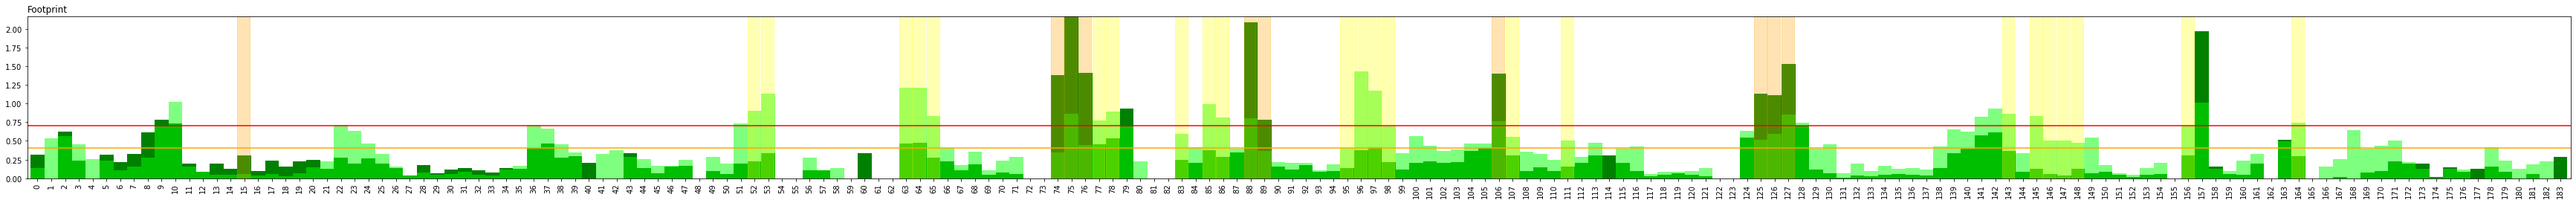

In [136]:
#display(footprint_ratio["ttest"])

plot_reactivity(footprint_ratio)

#display(footprint)